In [2]:
import netsim_summariser as summ

In [10]:
reload(summ)

<module 'netsim_summariser' from '/home/davidwu/REPOS/echidna_network/netsim_summariser.py'>

In [1]:
import itertools
import numpy as np
from scipy import stats
import polars as pl
from matplotlib import pyplot as plt, cycler
import seaborn as sns
from pathlib import Path

sns.set()

In [5]:
RECOMPUTE_METRICS = False

In [25]:
simulation_archives = {
    'temporal': './zero_sims/temporal/sim_all_30s.h5',
    'static': './zero_sims/static/sim_all_30s.h5',
    'snapshot': './zero_sims/snapshot/sims_with_30seeds_pseudocap.h5'
}

processed_results = {}

for label, archive in simulation_archives.items():
    if RECOMPUTE_METRICS:
        summariser = summ.Summariser(archive)
        result_df = summariser.metrics(ncpus=6, no_move=True, drop=[]).add_extent(30)
        result_df.write_parquet(Path(archive).with_name('metrics_30s.parquet'))
        processed_results[label] = result_df
    else:
        processed_results[label] = pl.read_parquet(Path(archive).with_name('metrics_30s.parquet'))


In [30]:
def compute_median_extent(df: pl.DataFrame):
    return df.group_by('seed').median().select('seed', 'extent')

def plot_median_extent(df: pl.DataFrame):
    median_extent = compute_median_extent(df)
    ordering = median_extent.sort('extent', descending=True).select('seed').to_series().to_list()

    fig, ax = plt.subplots(figsize=(18, 6))
    sns.boxplot(
        df.select('seed', 'extent'),
        x='seed',
        y='extent',
        order=ordering,
        orient='v',
        ax=ax
    )

    return (median_extent, ordering, fig, ax)

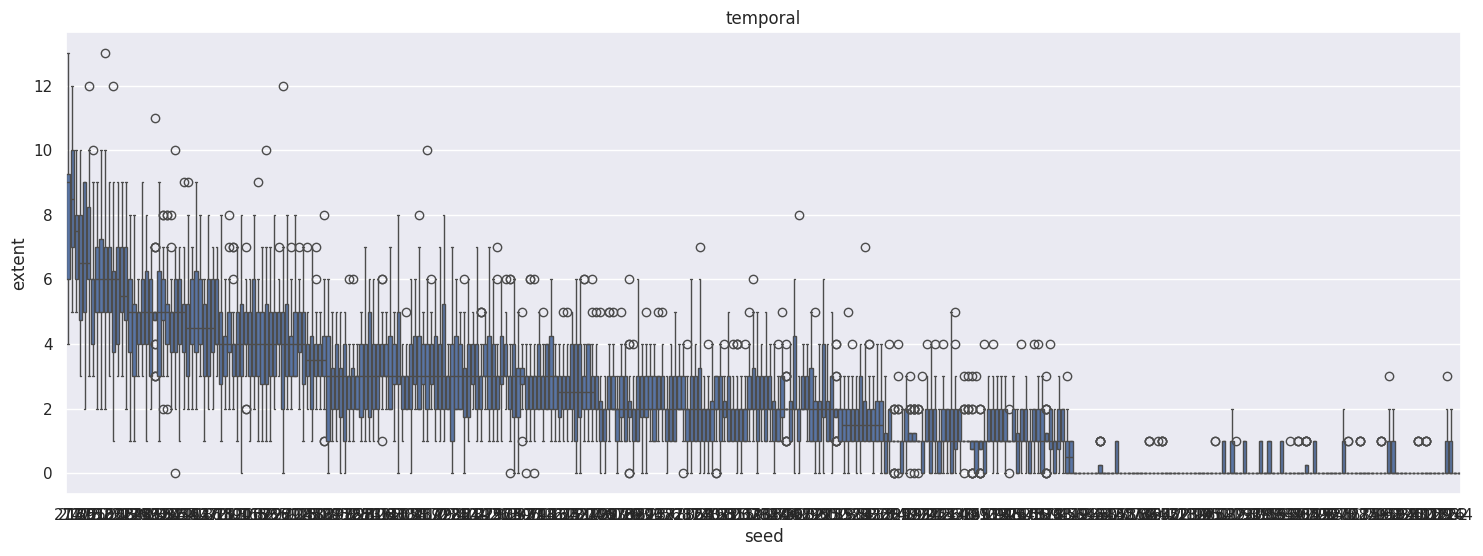

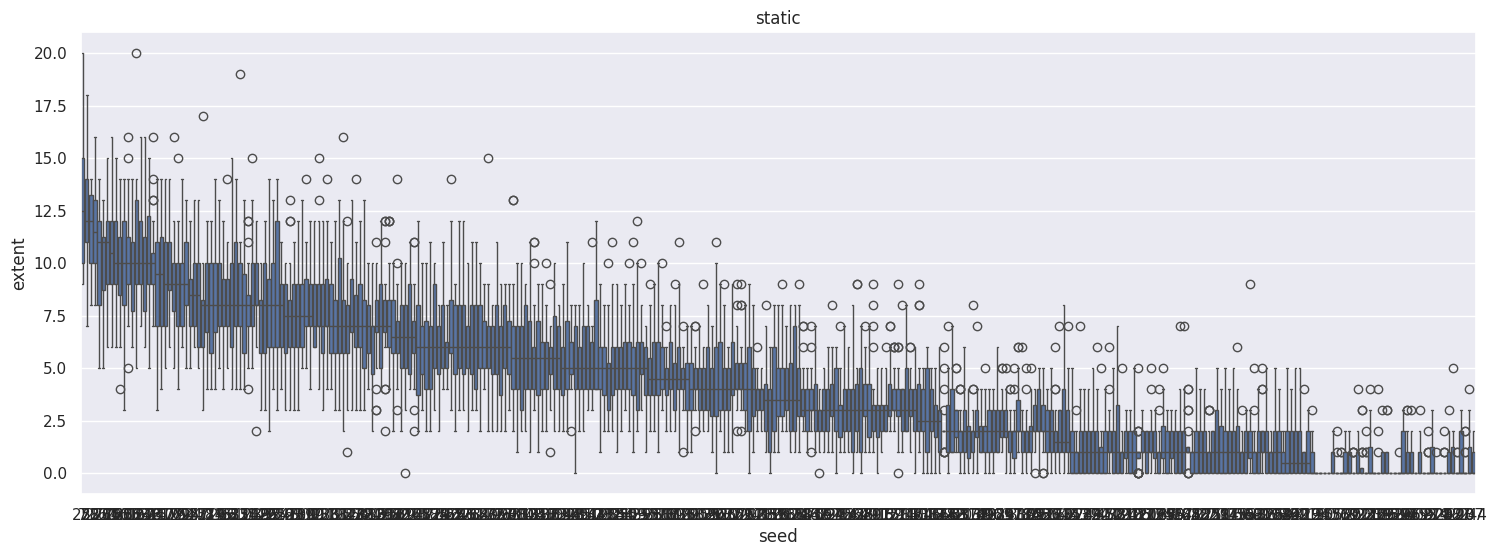

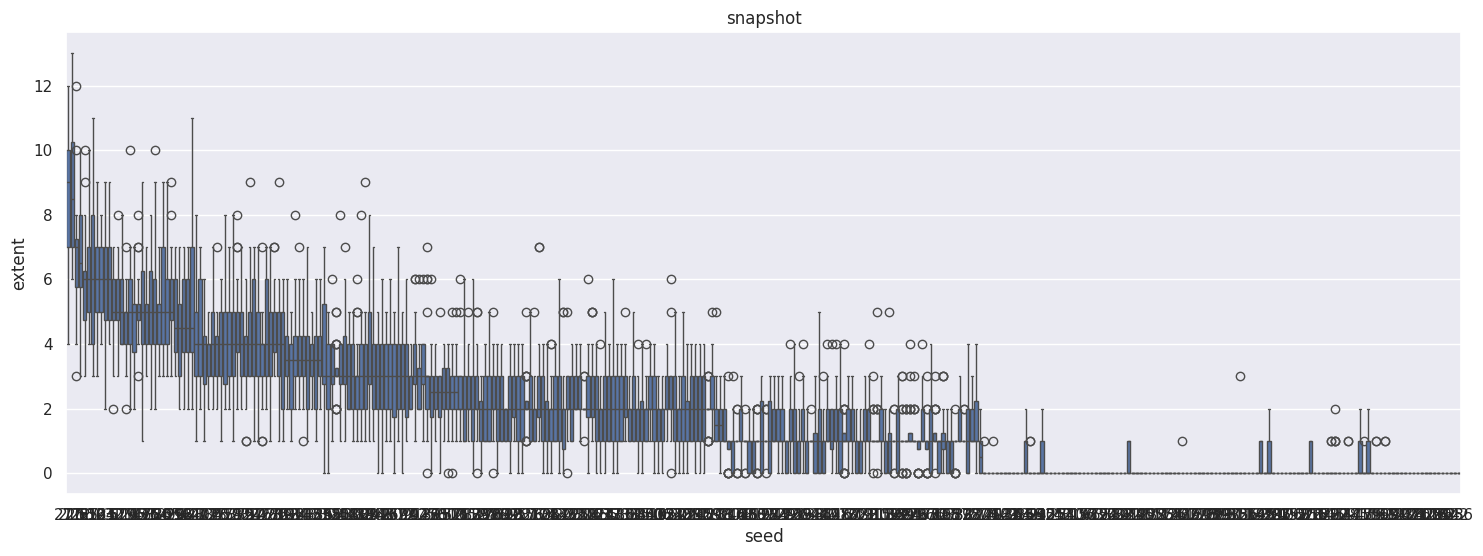

In [27]:
for k, df in processed_results.items():
    _, _, fig, ax = plot_median_extent(df)
    ax.set_title(k)

In [32]:
combined_median_df = pl.concat(
    [compute_median_extent(df).with_columns(pl.lit(label).alias('simulation'))
     for label, df in processed_results.items()]
)

combined_median_sort = combined_median_df.group_by('seed').median().select('seed', 'extent').sort('extent', descending=True).select('seed').with_row_index('sorted_seed')

combined_median_df = combined_median_df.join(combined_median_sort, on='seed')

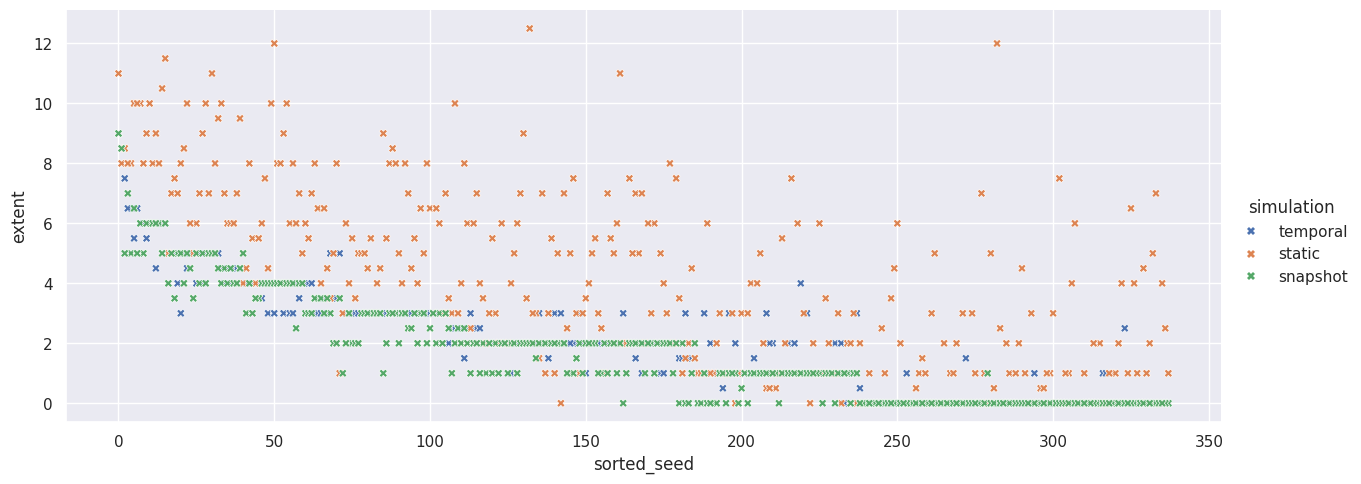

In [33]:
sns.relplot(
    combined_median_df,
    x='sorted_seed',
    y='extent',
    hue='simulation',
    marker='X',
    aspect=2.5,
)#.savefig("zero_extent_median_comparison.png", dpi=200)


In [34]:
combined_all_df = pl.concat(
    [df.select('seed', 'extent').with_columns(pl.lit(label).alias('simulation'), pl.col('extent').cast(pl.Int64))
     for label, df in processed_results.items()]
)

combined_sort_order = combined_all_df.group_by('seed').median().select('seed', 'extent').sort('extent', descending=True).select('seed').with_row_index('sorted_seed')

combined_all_df = combined_all_df.join(combined_sort_order, on='seed')

<Axes: ylabel='extent'>

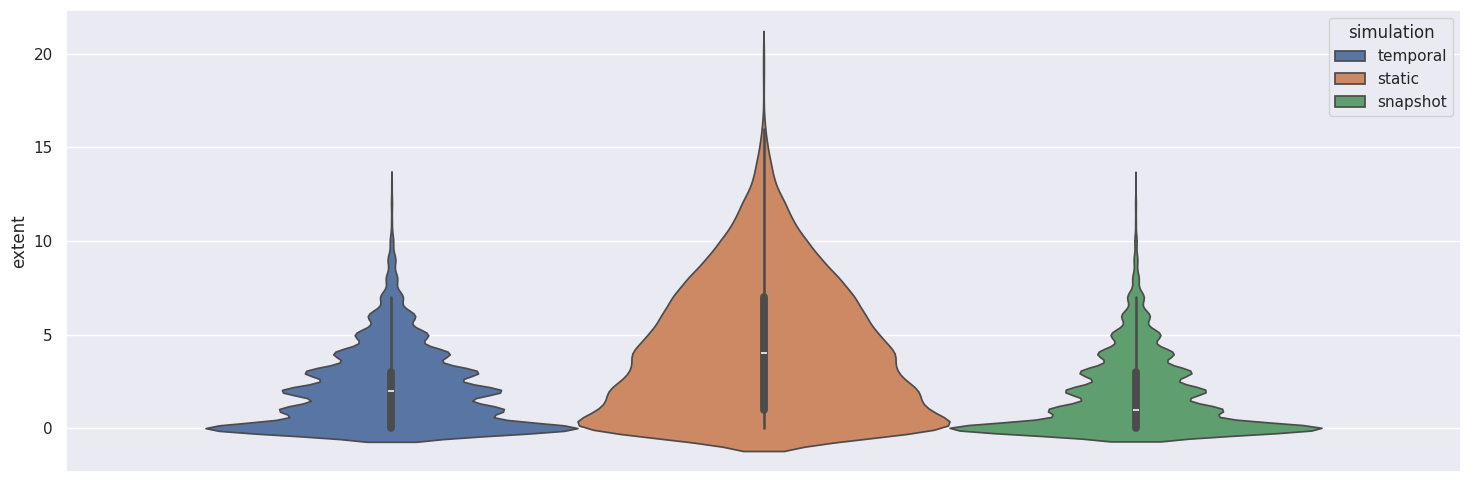

In [54]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.violinplot(
    combined_all_df,
    # x='sorted_seed',
    y='extent',
    hue='simulation',
    # log_scale=(True),
    # kind='box',
    # marker='.',
    # alpha=0.6,
    # aspect=2.5,
    ax=ax,
)
# ax.set_ylabel('extent + 1')
# ).savefig("zero_extent_all_comparison.png", dpi=200)
# fig.savefig('zero_extent_all_comparison.png', dpi=200)

In [49]:
paired_median_df = combined_median_df.pivot("simulation", index="sorted_seed", values="extent").fill_null(0.0)

In [50]:
for p1, p2 in itertools.combinations(['static', 'snapshot', 'temporal'], 2):
    print(p1, 'vs', p2)
    print(stats.ttest_rel(paired_median_df[p1], paired_median_df[p2], alternative='two-sided'))

static vs snapshot
TtestResult(statistic=19.199042757609984, pvalue=5.021375472553308e-56, df=337)
static vs temporal
TtestResult(statistic=15.489888425954147, pvalue=3.034498814730878e-41, df=337)
snapshot vs temporal
TtestResult(statistic=-7.433977467714621, pvalue=8.78103063275145e-13, df=337)


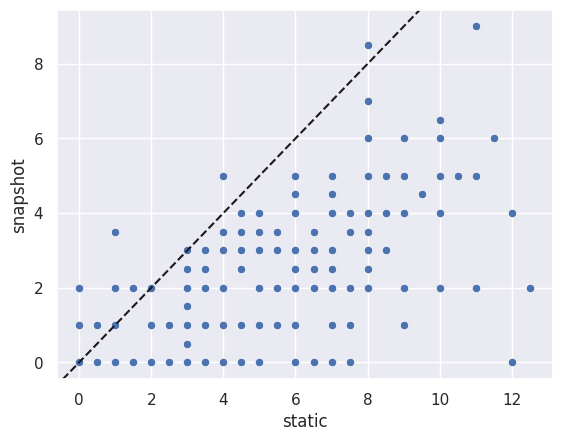

In [38]:
sns.scatterplot(paired_median_df, x='static', y='snapshot')
plt.axline((0,0), slope=1, color='k', linestyle='dashed')

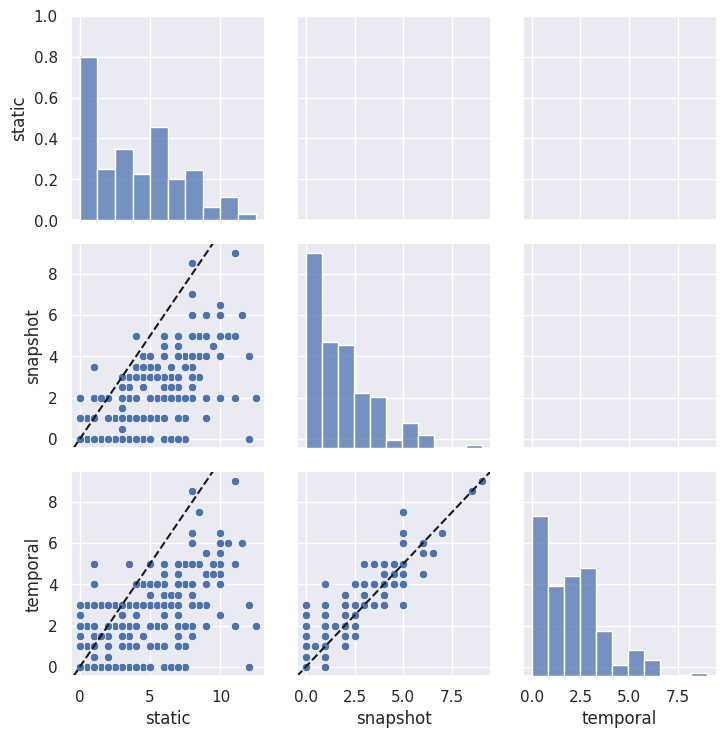

In [40]:
ppl = sns.PairGrid(paired_median_df.to_pandas(), vars=['static', 'snapshot', 'temporal'])
ppl.map_lower(sns.scatterplot)
ppl.map_diag(sns.histplot)
# ppl.map_upper(sns.scatterplot)
ppl.map_lower(lambda *a, **k: plt.axline((0,0), slope=1, linestyle='dashed', color='k'))
# ppl.savefig('zero_median_extent_pairedplot.png', dpi=200)

In [51]:
def extract_reappearance_time(df):

    reappearances = df.select(
        pl.col('seed'),
        pl.concat_list(pl.selectors.starts_with('hitting_time'))
        .list.eval(pl.element().filter(pl.element().is_not_null()).sort(), parallel=True)
        .list.get(1, null_on_oob=True)
        .alias('reappearance_time')
    )

    return reappearances

def get_sort_order(df, order='seed', by='reappearance_time'):
    return df.group_by(order).median().sort(by, descending=True).select(order).to_series().to_list()


In [67]:
reapp_snap = extract_reappearance_time(snapshot_df)

In [68]:
reapp_static = extract_reappearance_time(statichome_df)

In [124]:
reapp_temporal = extract_reappearance_time(temporal_df)

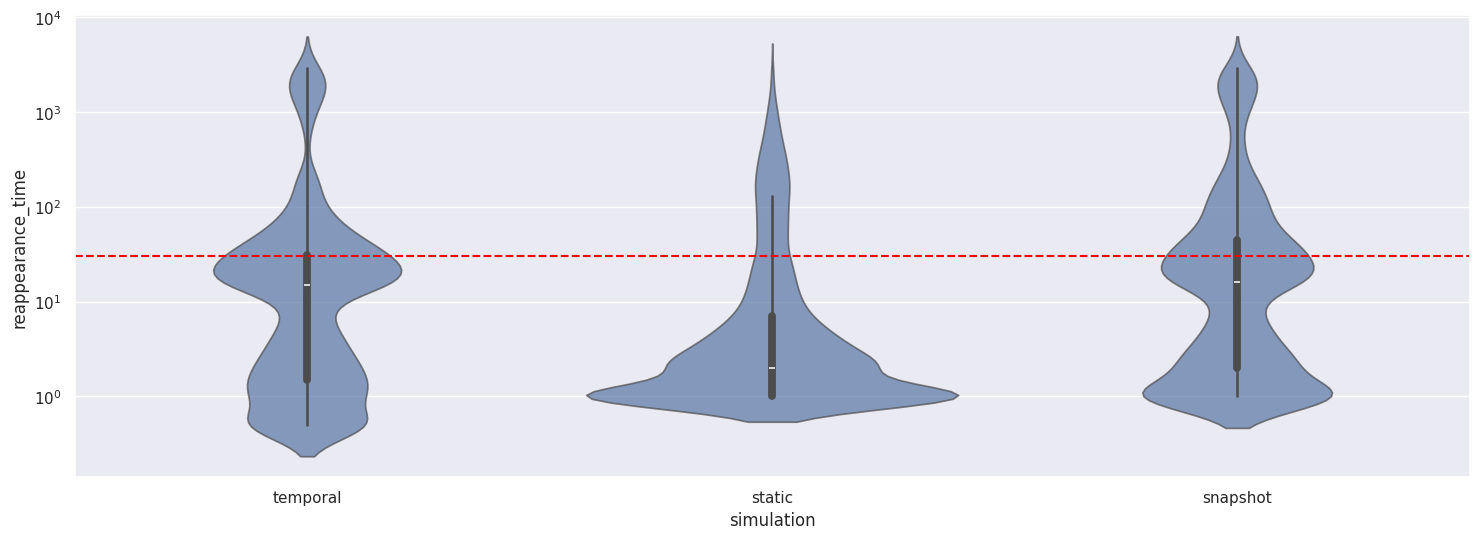

In [52]:
fig, ax = plt.subplots(figsize=(18, 6))

combined_reapp = pl.concat(
    [extract_reappearance_time(df).with_columns(pl.lit(label).alias('simulation'), 
                     (1.0 / pl.col('reappearance_time')).alias('reappearance_rate')
                    )
                     for label, df in processed_results.items()
    ]
)


reapp_order = get_sort_order(combined_reapp, by='reappearance_rate')

sns.violinplot(combined_reapp, y='reappearance_time', x='simulation',  orient='v', ax=ax, log_scale=(False, True), alpha=0.7,)
plt.axhline(30, color='red', linestyle='dashed')
# fig.savefig('zero_reappearance_time.png', dpi=200)
